Your name: Zack Strathe
    
    
K-State Honor Code: "On my honor, as a student, I have neither given nor received unauthorized aid on this academic work."

# Business and data understanding 

## Problem Statement:
- The goal of this project is to analyze data from news articles and Twitter regarding bitcoin. Since bitcoin is still relatively new and speculative, I would like to see if there are any trends that can be determined with sentiment analysis; my main interest is looking at the compound sentiment score using Vader Sentiment and determining if there are any trends in sentiment over time. Since it is difficult to get large numbers of historical tweets from Twitter, I am limiting my analysis of sentiment over time to news articles only. My hypothesis is that there will be a general upward trend in sentiment over time (as bitcoin has risen in price).

- In addition to analyzing sentiments about bitcoin, I will also generate a word cloud from Tweets, perform topic modeling on the news articles (to see if there are any other topics often appearing in news about bitcoin), and look at network analytics on the Twitter data to determine how "connected" the network is of those on Twitter who are talking about bitcoin.

- Ultimately I hope that this analysis gives some insight in to whether bitcoin is a valuable investment, without necessarily looking at the price movement over time.

# Data identification and collection
    - Collecting tweets using Twitter API
    - Collecting news articles with web scraping
    - Collecting bitcoin price data with web scraping

## Collecting tweets using Twitter API
- The below section of code will collect Tweets from a stream using the Twitter API, searching for the keyword 'bitcoin'
- This is the same code from the MIS 670 Twitter API module, but with some small modifications so that it collects tweets for a specific period of time and stops automatically. I collected 1,603 tweets in 10 minutes.
- The raw tweet data is saved to a JSON file to be later imported and used in analysis.

In [ ]:
# COLLECTING TWEETS
# http://adilmoujahid.com/posts/2014/07/twitter-analytics/
# If you're collecting tweets with very popular keywords (e.g., bigdata, iop, trump, applebee), use the following script.

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import time

#Variables that contains the user credentials to access Twitter API
consumer_key = 'VHUsk0wSsLffsyDh5QlyijIa6'
consumer_secret = 't3H0Kxzedpn9LuhxaSDKqHJV2tuGhLqicB2ggSnELeFPcupgHR'
access_token = '1274035852650389504-Zq0O8uKQPDSodjKb67HF4V1kWfIapk'
access_token_secret = '3IEpqN5x2vUKnl8ixlUY2QhEqd5w5Bp0VrgoSGQHEWtyx'

save_file = open('twitterdata_finalproj.json', 'a')

#This is a basic listener that just prints received tweets to stdout.
class StdOutListener(StreamListener):

    def on_data(self, data):
        if isinstance(data, dict):
            # An attempt to cut down on non English tweets.
            if data['user']['lang'] != 'en':
                return
        #print(data)
        save_file.write(str(data))
        return True

    def on_error(self, status):
        print(status)

if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    # modified to run for a specifed time using this example https://github.com/tweepy/tweepy/blob/master/tweepy/streaming.py#L45
    runtime = 600 # collect tweets for 10 minutes
    stream = Stream(auth, l)
    #This line filter Twitter Streams to capture data by the keyword 'bitcoin'
    stream.filter(track=['bitcoin'], is_async=True)
    time.sleep(runtime)
    stream.disconnect()
    save_file.close()

## Collecting news articles with web scraping
- To get news articles about bitcoin, I scraped article headlines and summaries from NYPost.com.
- From the site, I collected the title of the article, the date of the article, and the summary of the article.
- By iterating through 80 pages of the search results for articles about bitcoin, I was able to collect data from 790 articles from 2013 to present.

In [ ]:
import requests
from lxml import html

finaldata=[]

# web page format
web = "http://nypost.com/search/bitcoin/page/%s" 

# iterate through 12 pages and get article titles and append to finaldata list
for page in range(1,80):
    url = web % page
    data = html.fromstring(requests.get(url).text)
    
    for article in data.xpath("//li[contains(@id,'post')]"):
        title = str(article.xpath("div[2]/h3/a/text()")[0]).strip()
        date = str(article.xpath("div[2]/div/p[2]/text()")[0].split('|')[0]).strip()
        summary = str(article.xpath("div[3]/text()")[0]).strip()  
        finaldata.append([title, date, summary])
        
# create dataframe
df = pd.DataFrame(finaldata)
df.columns = ['Title','Date','Summary']
print(len(df))

# export data to csv to avoid requesting data again
df.to_csv('data/web_data.csv', index=False)

## Collecting bitcoin price data with web scraping
- To get price data for bitcoin, I'm scraping from a daily table of prices from coingecko.com. 
- The date range for the available price data is 4/28/13 through 5/1/21.
- From this data, I will get the yearly change in price to plot and compare against sentiment scores for each year.

In [ ]:
import requests
from lxml import html

finaldata=[]

#get html data from coingecko url
url = 'https://www.coingecko.com/en/coins/bitcoin/historical_data/usd?end_date=2021-05-01&start_date=2013-01-01'
data = html.fromstring(requests.get(url).text)
    
for article in data.xpath("//tbody/tr"):
    date = article.xpath("th/text()")
    price = article.xpath("td[3]/text()")
    finaldata.append([date, price])
        
# create dataframe
df = pd.DataFrame(finaldata)
df[0] = df[0].str[0] # remove brackets
df[1] = df[1].str[0].str.strip() # remove brackets and strip newline characters '\n'
df.columns = ['Date','Price'] # rename columns
df.head()

# export data to csv to avoid requesting data again
df.to_csv('data/btc_price_data.csv', index=False)

# Data cleaning & Text preprocessing
    - Importing modules and defining the text processing function
    - Importing tweets from JSON File
    - Importing and cleaning news article data from .csv
    - Importing and processing bitcoin price data from .csv

## Importing modules and defining the text processing function
- The text_process function:
    - removes non-alphanumeric characters
    - tokenizes
    - gets stemming words
    - removes stopwords (with the option to include a list of additional stopwords)
    - removes short words
    - and optionally converts the output into a string

In [1]:
# import packages 
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re
import numpy

# re-using text_process function from Topic Modeling HW to process lists
# added parameters (with default values) to customize pre-processing steps
def text_process(texts, return_string=False, add_stopwords = []):
    # remove non-alphabetic characters
    documents = [re.sub("[^a-zA-Z]+",' ', str(text)) for text in texts]

    # tokenize
    documents = [[word for word in text.lower().split()] for text in documents]

    # stemming words / lemmatization
    lmtzr = WordNetLemmatizer()
    documents = [[lmtzr.lemmatize(text) for text in item] for item in documents]

    # create stoplist
    stoplist = stopwords.words('english')
    [stoplist.append(i) for i in add_stopwords] # add more stopwords if included in parameters
    # remove stopwords
    documents = [[word for word in item if word not in stoplist] for item in documents]

    # remove short words
    documents = [[word for word in item if len(word) >= 3] for item in documents]
        
    # return text as a string if return_string = True; need to generate wordcloud
    if return_string == True:
        temp = []
        [[temp.append(word) for word in item] for item in documents]
        documents = ' '.join(temp)
           
    return documents

## Importing tweets from JSON File
- The tweets are loaded from the JSON file into a list called 'tweet_data'
- The list is further processed to create specific lists of data that can be used in analysis:
    - tweet text data
    - tweet text data for original tweets only
    - all hashtags
    - unique hashtags only

In [2]:
import json

# create an empty list to store our tweets in
tweet_data = []

# append each line of the data to our tweets list using the json module
for line in open('twitterdata_finalproj.json', encoding='utf-8'):
    try:
        tweet_data.append(json.loads(line))
    except:
        pass
    
tweet_texts = [t['text'] for t in tweet_data if 'text' in t] # append only if there is tweet text
print('Total tweets:', len(tweet_texts))

original_tweet_texts = [tweet for tweet in tweet_texts if 'rt @' not in tweet.lower()]
print('Total original tweets:', len(original_tweet_texts))

# get only hashtags from tweet_texts
hashtags = []
for tweet in tweet_texts:
    a = re.findall(r"(?<=#)\w+", tweet)
    if len(a) > 0:    
        for i in a: # iterate through the sub-list of hashtags from each tweet
            hashtags.append(i)       
hashtags = text_process(hashtags) # use text_process function on hashtags (mostly to remove non-alphanumeric text)
hashtags = [i for i in hashtags if len(i) > 0] # remove empty items in hashtags list      
print('Total hashtags:', len(hashtags))

unique_hashtags = [] # list to store unique hashtags after text pre-processing
for i in hashtags:
    #text_process(i) # call text_process function on sub-list of hashtags from each tweet
    for j in i: # iterate through each hashtag in each tweet and append to new list if not empty and if not already in list
        if len(j) > 0:
            if j.lower() not in unique_hashtags:
                unique_hashtags.append(j.lower())
print('Total unique hashtags:', len(unique_hashtags))

Total tweets: 1603
Total original tweets: 540
Total hashtags: 2239
Total unique hashtags: 300


## Importing and cleaning news article data from .csv
- The data scraped from NYPost.com is loaded from the .csv file into a dataframe
- The data is cleaned to:
    - Create a new column in the dataframe with only the year
    - Remove non-English characters from the 'Title' column
    - Remove non-English characters from the 'Summary' column

In [3]:
# IMPORT WEB SCRAPING DATA FROM CSV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

df_news = pd.read_csv('data/web_data.csv', encoding = 'ISO-8859-1') # create dataframe from .csv
print('Number of news articles:',len(df_news))

# CLEAN WEB SCRAPING DATA
# create new column "Year" with published year
df_news['Year'] = df_news['Date'].str.split(',').str[1]

# remove non-english characters from "Title" (keeping punctuation because it will affect VaderSentiment analysis)
df_news['Title'] = df_news['Title'].str.replace("[^A-Za-z0-9\$!\.? ]", "")

# remove non-english characters from "Summary" (keeping punctuation because it will affect VaderSentiment analysis)
df_news['Summary'] = df_news['Summary'].str.replace("[^A-Za-z0-9\$!\.? ]", "")

Number of news articles: 790


## Importing and processing bitcoin price data from .csv
- The bitcoin price data is loaded into a dataframe from a .csv file
- The data ranges from 2013 to 2021
- The goal from this data is to get the annual change in price, to do this the following steps are used:
    - Convert the date to a 'datetime' format that Pandas uses
    - Convert prices to an int (remove dollar sign and round from a float to an int)
    - Get a table of prices from the beginning of each year (or the first available date)
    - Get a table of prices from the end of each year (or the last available date)
    - Subtract the beginning table from the end table to get a new table of the price change for each year

In [4]:
# IMPORT BITCOIN PRICE DATA
df_btc = pd.read_csv('data/btc_price_data.csv', encoding = 'ISO-8859-1')

df_btc['Date'] = pd.to_datetime(df_btc.Date.astype(str)) # convert date to pandas datetime format
df_btc['Year'] = df_btc.Date.dt.year # add column for year
# remove non-numeric from price column
# keep "." to first convert price to a float, then round it as an int
df_btc['Price'] = df_btc['Price'].str.replace("[^0-9\.]", "").astype(float).astype(int)

# get the bitcoin price at the beginning of each year
df_btc_yearly_start = df_btc.loc[df_btc.groupby("Year")['Date'].idxmin()]['Price']
df_btc_yearly_start.index = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

# get the bitcoin price at the end of each year
df_btc_yearly_end = df_btc.loc[df_btc.groupby("Year")['Date'].idxmax()]['Price']
df_btc_yearly_end.index = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

# calculate the yearly change in bitcoin price (end price - start price)
df_price_change = df_btc_yearly_end - df_btc_yearly_start
print(df_price_change)

2013      620
2014     -450
2015      118
2016      532
2017    13841
2018   -10284
2019     3548
2020    21642
2021    28807
Name: Price, dtype: int32


# Descriptive analytics
    - Word Cloud from Tweets
    - Bi-gram Frequency from Original Tweets
    - Visualization of Bi-grams from Tweets

## Word Cloud from Tweets
- The word cloud is generated with 5,000 words from the text of tweets
- The cloud is generated using a mask (for shape and color) of the bitcoin logo
- To get the text for generating the cloud, the tweet_texts list is processed using the already defined text_process function, with the additional parameter of "return_string=True")

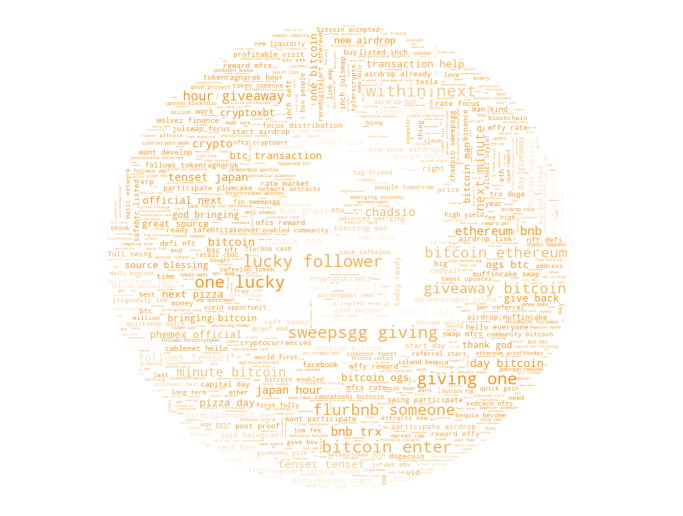

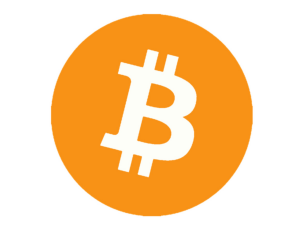

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import nltk 
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import re

# add stopwords 
stopwords_wc = list(STOPWORDS) + (nltk.corpus.stopwords.words('english'))
more_stopwords = ['RT','https','retweet','retweets','follow','CO']
for word in more_stopwords:
    stopwords_wc.append(word) 

# add mask
mask = np.array(Image.open('data/btc_logo.jpg'))

# add mask colors
image_colors = ImageColorGenerator(mask)

# get pre-processed tweet texts as a string for wordcloud
word_string = text_process(tweet_texts, return_string = True)

# create WordCloud object
wc = WordCloud(background_color='white', max_words=5000, mask=mask, stopwords=stopwords_wc,
               random_state=75,max_font_size=30).generate(word_string) 

# plot wordcloud
plt.figure(figsize=(12,12))
plt.imshow(wc.recolor(color_func=image_colors))
plt.axis('off')
plt.show()

# show mask
plt.figure()
plt.imshow(mask)
plt.axis("off")
plt.show;

## Word Fequency (Bi-grams) from Original Tweets
- Bi-grams are generated from the list of original tweets, and pre-processed using the text_process function
- The following prints the five most-common bi-grams from the tweets

In [6]:
from nltk import FreqDist
tweet_tokens = text_process(original_tweet_texts, add_stopwords=['http']) # get tokens from original tweets

# get original tweet tokens in a single list 'teet_tokens_new'
tweet_tokens_new = []
for i in tweet_tokens:
    for j in i:
        tweet_tokens_new.append(j)

bigrams = nltk.bigrams(tweet_tokens_new) # get bigrams from tokens
fdist = nltk.FreqDist(bigrams) # get bigram nltk frequency distribution
popular = fdist.most_common(5) # get 5 most popular bigrams
print(popular)

[(('thank', 'god'), 48), (('god', 'bringing'), 48), (('bringing', 'bitcoin'), 48), (('bitcoin', 'man'), 48), (('man', 'great'), 46)]


## Data Visualization of Bi-grams
- Tweet bi-gram frequency displayed with a bar chart

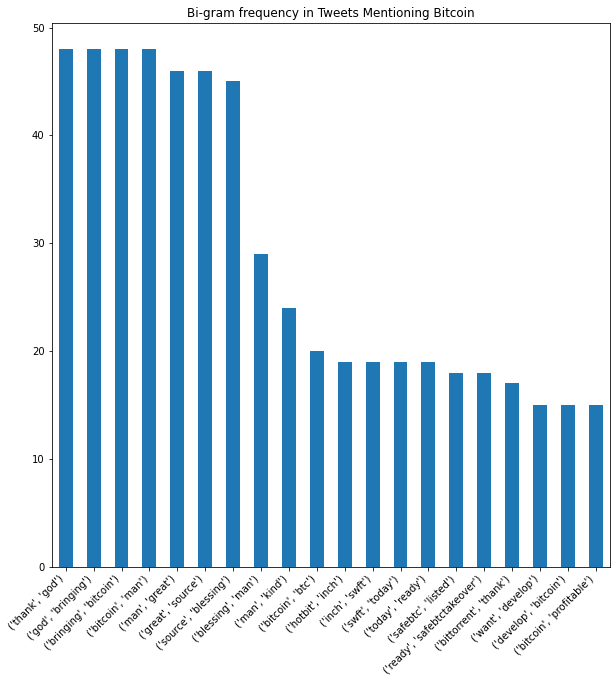

In [7]:
df_bigrams = pd.DataFrame(fdist.most_common(20))
ax = df_bigrams.plot(kind='bar', legend=False, figsize=(10,10),title='Bi-gram frequency in Tweets Mentioning Bitcoin')
ax.set_xticklabels(df_bigrams[0], rotation=45, ha='right');


# Content analytics
    - Sentiment Analysis from News Data
    - Plotting Bitcoin Price Change and Sentiment from News Data
    - Sentiment Analysis from Tweets
    - Topic Modeling from News Data

## Sentiment Analysis - News Article Data 
- The goal of this sentiment analysis on news articles is to ultimately get the mean sentiment score for articles by year, which will be used to compare to the price change in bitcoin for the corresponding year. 
- First, new columns are added for both 'TitleSentiment' and 'SummarySentiment' with the calculated compound Vader Sentiment score.
- To get the sentiment score by year, the dataframe is grouped by 'Year' with the mean() function and stored as a new variable 'score_by_year'

In [9]:
# SENTIMENT ANALYSIS WITH WEB SCRAPING DATA
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer() # initialize VaderSentiment

# create new dataframe columns with compound VaderSentiment for both Title and Summary
df_news['TitleSentiment'] = df_news['Title'].apply(lambda x: analyzer.polarity_scores(x)['compound']) 
df_news['SummarySentiment'] = df_news['Summary'].apply(lambda x: analyzer.polarity_scores(x)['compound']) 

score_by_year = df_news.groupby('Year').mean()
print(score_by_year, end='\n\n\n') # print mean news article sentiment for each year

print(df_news.describe()) # print news article sentiment overall statistics


       TitleSentiment  SummarySentiment
Year                                   
 2013        0.115880         -0.103010
 2014       -0.006624         -0.002238
 2015       -0.128974          0.016905
 2016        0.078438          0.000343
 2017       -0.086820          0.016046
 2018       -0.088839          0.020736
 2019       -0.139275         -0.095458
 2020       -0.007200         -0.050552
 2021       -0.032593          0.083261


       TitleSentiment  SummarySentiment
count      790.000000        790.000000
mean        -0.060538          0.002755
std          0.348297          0.443647
min         -0.928700         -0.967400
25%         -0.296000         -0.318200
50%          0.000000          0.000000
75%          0.000000          0.335125
max          0.918600          0.943700


- Overall, the sentiment from both news article titles and summaries is mostly neutral overall, with the titles being slightly negative in sentiment (mean score of -0.06 across all years) and the summaries being slightly positive in sentiment (mean score of 0.0027 across all years).

- There appears to be some variation in sentiment between years (though still not varying much from 0).

In [10]:
pos_title_count = df_news['Title'].loc[df_news['TitleSentiment'] > 0].count()
neg_title_count = df_news['Title'].loc[df_news['TitleSentiment'] < 0].count()
neut_title_count = df_news['Title'].loc[df_news['TitleSentiment'] == 0].count()

pos_summary_count = df_news['Title'].loc[df_news['SummarySentiment'] > 0].count()
neg_summary_count = df_news['Title'].loc[df_news['SummarySentiment'] < 0].count()
neut_summary_count = df_news['Title'].loc[df_news['SummarySentiment'] == 0].count()

# print statistics for number of pos, neg, and neutral titles
print(f'Out of {len(df_news)} articles about bitcoin, there were \
{pos_title_count} positive titles ({(pos_title_count/len(df_news))*100:.2f}%), \
{neg_title_count} negative titles ({(neg_title_count/len(df_news))*100:.2f}%), \
and {neut_title_count} neutral titles({(neut_title_count/len(df_news))*100:.2f}%).',end='\n\n')
# print statistics for number of pos, neg, and neutral summaries
print(f'Out of {len(df_news)} articles about bitcoin, there were \
{pos_summary_count} positive summaries ({(pos_summary_count/len(df_news))*100:.2f}%), \
{neg_summary_count} negative summaries ({(neg_summary_count/len(df_news))*100:.2f}%), \
and {neut_summary_count} neutral summaries({(neut_summary_count/len(df_news))*100:.2f}%).')

Out of 790 articles about bitcoin, there were 182 positive titles (23.04%), 266 negative titles (33.67%), and 342 neutral titles(43.29%).

Out of 790 articles about bitcoin, there were 328 positive summaries (41.52%), 311 negative summaries (39.37%), and 151 neutral summaries(19.11%).


- Since the article summaries have fewer neutral sentiment scores (and because the summaries contain more words to extract scores from), I'm assuming that the 'summary' scores contain more meaningful data and will use only those for further analysis.

### Plotting Bitcoin Price Change and Sentiment from News Data

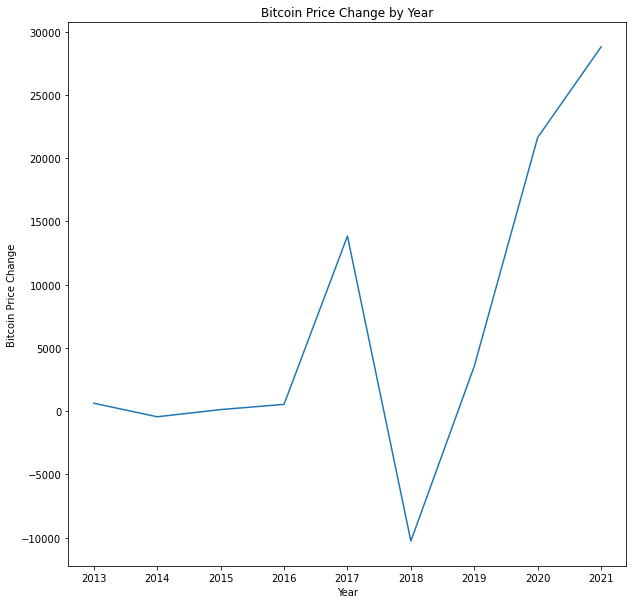

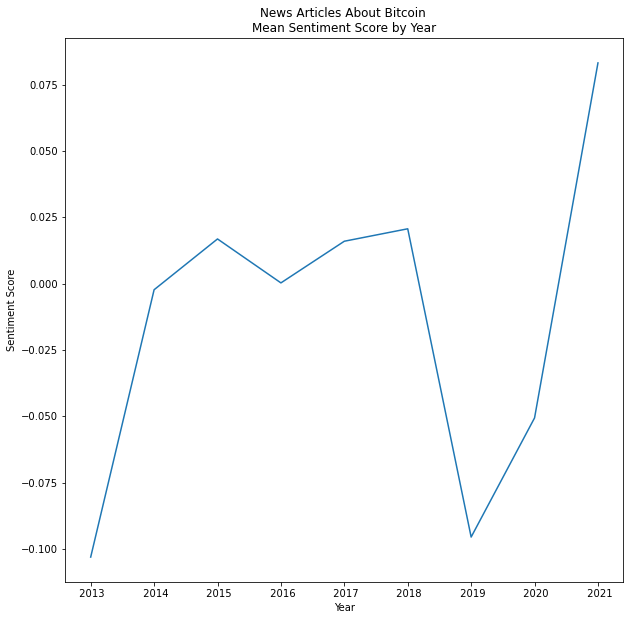

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# plot bitcoin price calculated change per year
plt.figure(figsize=(10, 10))
plt.plot(df_price_change);
plt.xlabel("Year")
plt.ylabel("Bitcoin Price Change")
plt.title("Bitcoin Price Change by Year");

# plot mean sentiment scores by year from article summaries
plt.figure(figsize=(10, 10))
plt.plot(score_by_year['SummarySentiment'], label='Summary Sentiment');
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.title("News Articles About Bitcoin \nMean Sentiment Score by Year");

- There appears to be some similarity between the 'Bitcoin Price Change by Year' graph and the 'Mean Sentiment Score by Year' graphs, especially since 2019.
- The sentiment score appears to lag behind the change in bitcoin price by about a year. 
    - For example, there was a large negative price change in bitcoin in 2018, but sentiment from news articles was slightly positive. However, in 2019 there was a (relatively) low sentiment score (although still close to neutral).

## Sentiment Analysis - Twitter Data (original tweets only)
- The original tweet texts are imported into a dataframe, and a new column is appended with the compound sentiment score. 
- After filtering non-alphanumeric data from the tweets, there were still a significant number of non-English tweets, which all had a sentiment score of 0. To improve the accuracy of the mean sentiment score from the tweets, I created a new dataframe only containing non-zero sentiment scores. This also reduced the sample size from 540 original tweets to 310, which should still be large enough for a fairly accurate estimate.

In [12]:
# create dataframe from tweet

df_tweets = pd.DataFrame(original_tweet_texts)
len(df_tweets)
df_tweets[0] = df_tweets[0].str.replace("[^A-Za-z0-9\$!\.? ]", "") # remove non-alphanumeric except punctuation
df_tweets[1] = df_tweets[0].apply(lambda x: analyzer.polarity_scores(x)['compound']) # get vader sentiment score
df_tweets.columns = ['Tweet','Compound Sentiment Score'] # rename columns

# I found that there were too many non-english tweets even afer removing non-alphanumeric characters
# so I'm also removing all tweets that have a compound score of 0 before calculating statistics
df_valid_ = df_tweets[df_tweets['Compound Sentiment Score'] != 0] 
print(df_valid_.describe())

# get positive tweet cound and negative tweet count
pos_tweet_count = df_valid_['Tweet'].loc[df_valid_['Compound Sentiment Score'] > 0].count()
neg_tweet_count = df_valid_['Tweet'].loc[df_valid_['Compound Sentiment Score'] < 0].count()

# print statistics for number of pos and neg tweets
print(f'\nOut of {len(df_valid_)} tweets about bitcoin, there were \
{pos_tweet_count} positive tweets ({(pos_tweet_count/len(df_valid_))*100:.2f}%) and \
{neg_tweet_count} negative tweets ({(neg_tweet_count/len(df_valid_))*100:.2f}%).',end='\n\n')

       Compound Sentiment Score
count                310.000000
mean                   0.415893
std                    0.419916
min                   -0.827100
25%                    0.238025
50%                    0.473800
75%                    0.750450
max                    0.982900

Out of 310 tweets about bitcoin, there were 261 positive tweets (84.19%) and 49 negative tweets (15.81%).



- The sentiment score from the tweets is fairly positive with a mean Vader Sentiment compound score of 0.42.
- In terms of percentage overall, 84% of tweets about bitcoin were positive, while only 16% were negative.
- This seems to confirm that the current "point in time" sentiment of bitcoin is fairly positive.

## Topic Modeling - News Article Data
- To build the topic model from the news article summary data, first the dataframe column is converted to a list and stored as 'topic_data'
- The data then is pre-processed using the text_process function
- Then a gensim dictionary is generated from the data, with tokens that appear in less than 2 documents removed
- Next, a corpus is generated from the documents and dictionary

In [15]:
# gensim for topic modeling
import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

# NMF topic modeling packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

topic_data = df_news['Summary'].values.tolist() # get news article summaries from df_news in a list 

# using text_process function to pre-process data (remove non-alpha, tokenize, get stemming words, remove stopwords, and remove short words)
documents = text_process(topic_data, add_stopwords=['said']) 

# use gensim to create a dictionary representation of the documents
dictionary = Dictionary(documents)

# remove tokens that appear in less than 2 documents 
dictionary.filter_extremes(no_below=2)

# save dictionary for later use
dictionary.save('data/finalproj_data.dict') 

# create corpus - convert words to vectors or integers
corpus = [dictionary.doc2bow(text) for text in documents]

# save corpus for later use
corpora.MmCorpus.serialize('data/finalproj_corpus.mm', corpus)

print('Dictionary length:', len(dictionary),'words')
print('Corpus length:', len(corpus), 'documents')

Dictionary length: 1711 words
Corpus length: 790 documents


### Get ideal number of topics for the model:
- To get the ideal number of topics for the model, I'm looping through the range of 2 to 6 topics and comparing the coherence scores that are generated from each LDA model.


-4.24380251036093
-5.598015861538857
-6.651933657110366
-5.9141842218052885
-6.552843138688059


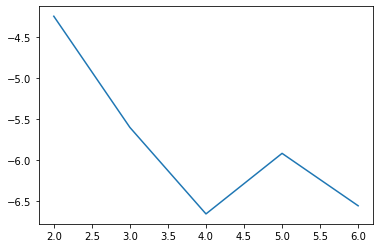

In [194]:
import matplotlib.pyplot as plt
import numpy as np

# Testing different number of topics to get the ideal model
np.random.seed(1) 
k_range = list(range(2,7))   # range 2 through 6
scores = []
for k in k_range:
    LdaModel = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=50)
    cm = CoherenceModel(model=LdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    print((cm.get_coherence()))
    scores.append(cm.get_coherence())
    
plt.figure()
plt.plot(k_range, scores)

- It looks like the ideal number of topics from this dataset is 2.

### Get term-topic distribution:
- Using two topics determined from the previous step, I'm building a model using the LDA topic modeling algorithm.
- From the model, I'm getting the term-topic distribution and printing the topics, which will show the probability of words belonging to each topic.

In [16]:
# set number of topics to use for elsewhere on this notebook
num_topics = 2

# build a lda topic model 
numpy.random.seed(1) # setting random seed to get the same results each time. 
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, passes=50)

# print term-topic distribution
model.show_topics()

[(0,
  '0.029*"bitcoin" + 0.015*"cryptocurrency" + 0.010*"digital" + 0.009*"price" + 0.008*"million" + 0.008*"currency" + 0.007*"street" + 0.007*"wall" + 0.006*"tuesday" + 0.006*"monday"'),
 (1,
  '0.022*"bitcoin" + 0.014*"new" + 0.008*"one" + 0.007*"year" + 0.007*"currency" + 0.006*"york" + 0.006*"cryptocurrency" + 0.005*"twitter" + 0.005*"account" + 0.005*"digital"')]

- There doesn't look to be much distinction between the two topics. Both topics include the word "bitcoin" with a high probability, as well as the words "cryptocurrency", "currency", "digital". 
- Therefore it appears that the news data didn't contain any other "hidden" topics accompanying the topic of bitcoin.

# Network analytics
    - Twitter Mention Network Visualization
    - Node Level Metrics
    - Network Level Metrics

## Twitter mention network visualization

### Create "mention network" and save to .csv to import into Gephi
- The raw tweet data is processed to search whether another twitter user is mentioned in a tweet
- If a mention is found, the user who tweeted and the user that was mentioned are both appended to a row in the 'mention network' .csv file

In [205]:
import csv
# open csv file to save mention network
openfile = open("data/finalproj_mentionnetwork.csv","w", newline='')
w = csv.writer(openfile)

# get mention network from raw tweet data
tweet_mentions = [[t['user']['screen_name'], t['text']] for t in tweet_data if 'text' in t] 
for tweet in tweet_mentions:
    a = re.findall(r"(?<=@)\w+", tweet[1]) # only write mention data if '@' is found in the tweet text
    for i in a:
        w.writerow([tweet[0], i])
        
openfile.close() # close csv file

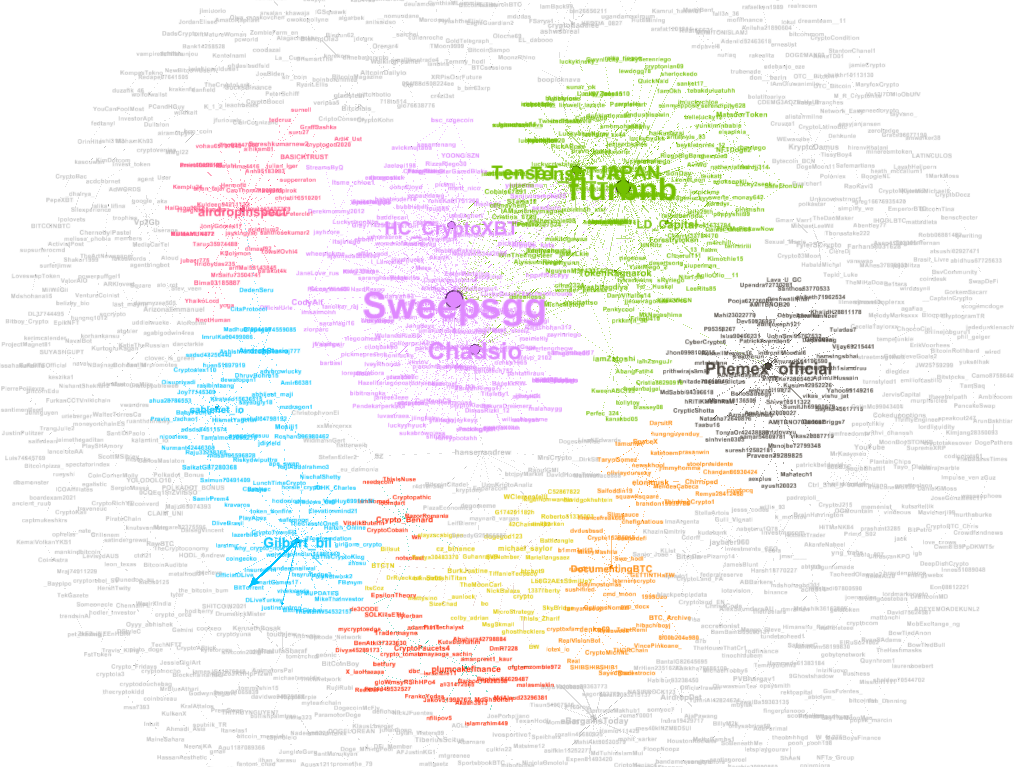

In [214]:
from IPython.display import Image
Image('mention_network.png')

### Node Level Metrics
- Degrees: 
    - Because the size of nodes are ranked by degree in the visualization it's clear that there are a handful of twitter accounts that received a lot of mentions comparatively to the rest. The accounts 'Sweepsgg' and 'flurbnb' appear to be the largest, and likewise have the highest degree scores.
- Betweenness Centrality:
    - It's difficult to tell from the visualization, but the level of 'connectedness' in the twitter mentions data is fairly low. So as a result, very few twitter accounts have a significant betweenness centrality score. Out of 1,618 nodes in the data, only 11 have a betweenness centrality score above 0, and with all also having fairly few degrees.
- Eigenvector Centrality:
    - The Eigenvector centrality scores appear to follow very closely with in-degrees in this set of data. The Twitter accounts that have been mentioned a lot have a very high eigenvector score, while those with very few mentions have a low score. The importance of 'in-degree' (being mentioned) versus 'out-degree' (mentioning someone else) is clear here in a directed network. There are some accounts with very high total number of degrees, but most connections are 'out-degree' and retult in a low eigenvector score. In particular, one account "Gilbert_bil" has 47 degrees an an eigenvector centrality score of 0. 
    


### Network Level Metrics
- Clustering coefficient:
    - The vast majority of the Twitter accounts in this data set have a very low clustering coefficient, showing that overall there isn't much connectivity among the nodes in the network.

- Graph Density:
    - Likewise with the average clustering coefficient being very low, the graph density is extremely low (0.001). This further shows that this graph is very sparse, and that while there are a lot of individual nodes, there are relatively few connections among them. From the visualization it appears that most connections in the Twitter mention data are mentions of the most popular accounts.
- Modularity: 
    - In the graph visualization there are clearly 8 fairly large modules (shown in color). Though in total Gephi calculated 301 modules. Most modules in this data set are very small (only two or three nodes) and are shown in gray on the visualization. 


# Storytelling & Conclusion

- With the relatively new and highly speculative nature of bitcoin, it can be tricky to determine whether it may be a good asset to invest in. You can look at historical price performance charts, but that doesn't give any insight into what I think is largely driving the price of a speculative asset like bitcoin: how people feel about it.

- By using Vader Sentiment to get the compound sentiment scores of 790 news articles from 2013 to present, I was able to determine that there does appear to be some level of relation between the price change in bitcoin and the sentiment found in news articles. Although the sentiment scores from the news articles tended to be very close to neutral, there is some variance in the sentiment score from year to year, what seems like enough to indicate a changing sentiment. However, one key takeaway from this analysis is that the sentiment in the news articles is not timely with the change in bitcoin price and appears to lag behind by about a year.

- Since news articles do not provide us with a timely-enough sentiment to make any judgement about the current price of bitcoin, Twitter seems like a great alternative that could deliver a constant stream of sentiment scores regarding bitcoin. Using the Twitter API, I collected 1,603 tweets containing the word 'bitcoin' over a 10 minute period. From those tweets, I attempted to further narrow down the data to only original tweets in English and resulted in 310 tweets. Overall there was a fairly positive sentiment, and out of 310 tweets about bitcoin, there were 261 positive tweets (84.19%) and 49 negative tweets (15.81%), with an overall sentiment score of 0.42. Since the tweets were only collected for a specific 10 minute period of time (on 4/29/21 appprox. 12 a.m. cst), the results may not accurately reflect the real sentiment, although the 0.42 sentiment score sounds reasonable given that bitcoin has appreciated in price by $28,807 so far in 2021. So currently, the sentiment data does seem to show that bitcoin is a good investment. And going forward, I believe that these results show potential to further study sentiment analysis on bitcoin, maybe by continuously sampling streams of tweets from the Twitter API to get a more accurate real-time look at the change in sentiment over time, which could correlate the with the change in price.